Python version used: **3.9.13**

# Go back through everything and add tiles explaining and justifying choices, clean everything up and run fully

# Also check it runs in colab

Imports:

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# gensim imports
from gensim.models import Word2Vec
from gensim import utils

# other imports
import csv
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Check that CUDA is available (when using my own system):

In [2]:
torch.cuda.is_available()

True

# Q1:

(a)

In [3]:
with open("PADL-Q1.csv") as q1_file:
  q1_data = []
  q1_dataset = csv.reader(q1_file, delimiter=',')
  for row in q1_dataset:
    if row[0] != 'x1':
      q1_data.append(row)

In [4]:
pca = PCA(n_components=5)
pca.fit(q1_data)
newData = pca.fit_transform(q1_data)
pca_var_percentage = pca.explained_variance_ratio_
print(pca_var_percentage)

[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]


In [5]:
three_dims = pca_var_percentage[0]+pca_var_percentage[1]+pca_var_percentage[2]
print("Information retained with 3 variables = %f%%\n"%(three_dims*100.0))
print("Information retained with 4 variables = %f%%"%((three_dims + pca_var_percentage[3])*100.0))

Information retained with 3 variables = 94.177351%

Information retained with 4 variables = 98.783177%


Reducing the dimensionality of the dataset by 1 dimension causes information loss of 1.22%. Reducing it by 2 dimensions (down to 3) causes information loss of 5.82% however it is now possible to plot the dataset on a 3D axis, whereas this is not possible with 4 dimensions. Therefore, D_min = 3.





(b)

In [6]:
pca2 = PCA(n_components=3)
pca2.fit(q1_data)
newData2 = pca2.fit_transform(q1_data)
pca2_components = pca2.components_

In [7]:
i = 1
for line in pca2_components:
    print("PC%i: %f*x1 + %f*x2 + %f*x3 + %f*x4 + %f*x5\n"%(i,line[0],line[1],line[2],line[3],line[4]))
    i+=1

PC1: -0.092819*x1 + 0.025272*x2 + -0.348770*x3 + 0.145083*x4 + -0.920900*x5

PC2: 0.005624*x1 + -0.298705*x2 + -0.114221*x3 + -0.940623*x4 + -0.113695*x5

PC3: 0.112668*x1 + -0.133156*x2 + 0.914203*x3 + -0.023934*x4 + -0.365014*x5



# Q2:

Read and split dataset into _data_ and _targets_ Pandas dataframes:

In [8]:
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_target = q2_data['out']
q2_data = q2_data.drop('out',axis=1)
X,y = q2_data[['x','y','z','w']],q2_target

In [9]:
print(X.shape)
print(y.shape)

(80, 4)
(80,)


Plot each variable against the output:

Text(0.5, 1.0, 'w')

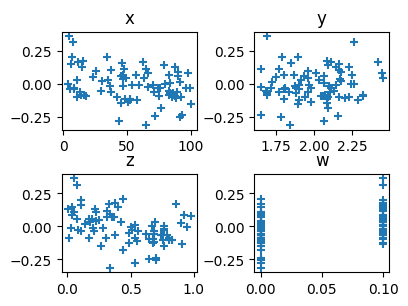

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(4,3))
fig.tight_layout()
ax[0][0].scatter(q2_data['x'],q2_target,marker='+')
ax[0][0].set_title("x")
ax[0][1].scatter(q2_data['y'],q2_target,marker='+')
ax[0][1].set_title("y")
ax[1][0].scatter(q2_data['z'],q2_target,marker='+')
ax[1][0].set_title("z")
ax[1][1].scatter(q2_data['w'],q2_target,marker='+')
ax[1][1].set_title("w")

(a)

The function _polynomial_basis_ returns the basis functions for a fit of the data to an n degree polynomial, along with fitting and transforming them to the data

In [11]:
def polynomial_basis(X,degree):
    poly = PolynomialFeatures(degree,include_bias=False)
    functions = poly.fit(X).get_feature_names_out()
    return functions,poly.fit_transform(X)

The function _scale_data_ scales the data using a scaler provided in sklearn

In [12]:
def scale_data(X_train,X_test,scaler):
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

The function _evaluate_basis_ takes the train and test data and applies the _polynomial_basis_ function to it, along with scaling if necessary, and outputs the r2 score as well as the basis functions for a given degree polynomial fit to a LinearRegression model

In [13]:
def evaluate_basis(X_train, X_test, y_train, y_test, transform_func, scaler=None, **transform_params):
    # Data scaling
    if scaler:
        X_train, X_test = scale_data(X_train, X_test, scaler)
    
    # Get poly basis functions
    X_train_basis_functions,X_train_transformed = transform_func(X_train, **transform_params)
    X_test_basis_functions,X_test_transformed = transform_func(X_test, **transform_params)
    
    model = LinearRegression()
    model.fit(X_train_transformed, y_train)
    
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return train_r2, test_r2, X_train_basis_functions

Print out running the above function for various degree polynomials

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=12)

print("Polynomial basis functions with StandardScaler:\n")
for degree in range(1, 6):
    train_r2, test_r2, basis_f = evaluate_basis(X_train, X_test, y_train, y_test, polynomial_basis, scaler=StandardScaler(), degree=degree)
    print(f'Polynomial Degree {degree} - Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')
    print(f'Number of basis functions:{basis_f.shape}')
    # Uncomment this line to see the actual basis functions
    # print(f'Basis functions:{basis_f}')

print("\n\nPolynomial basis functions with MinMaxScaler (normalisation):\n")
for degree in range(1, 6):
    train_r2, test_r2, basis_f = evaluate_basis(X_train, X_test, y_train, y_test, polynomial_basis, scaler=MinMaxScaler(), degree=degree)
    print(f'Polynomial Degree {degree} - Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')
    print(f'Number of basis functions:{basis_f.shape}')
    # Uncomment this line to see the actual basis functions
    # print(f'Basis functions:{basis_f}')

Polynomial basis functions with StandardScaler:

Polynomial Degree 1 - Train R2: 0.4206, Test R2: 0.0241
Number of basis functions:(4,)
Polynomial Degree 2 - Train R2: 0.5327, Test R2: 0.1897
Number of basis functions:(14,)
Polynomial Degree 3 - Train R2: 0.7229, Test R2: -1.4782
Number of basis functions:(34,)
Polynomial Degree 4 - Train R2: 0.9984, Test R2: -21569.3613
Number of basis functions:(69,)
Polynomial Degree 5 - Train R2: 1.0000, Test R2: -168.8245
Number of basis functions:(125,)


Polynomial basis functions with MinMaxScaler (normalisation):

Polynomial Degree 1 - Train R2: 0.4206, Test R2: 0.0241
Number of basis functions:(4,)
Polynomial Degree 2 - Train R2: 0.5328, Test R2: 0.1903
Number of basis functions:(14,)
Polynomial Degree 3 - Train R2: 0.7238, Test R2: -1.4826
Number of basis functions:(34,)
Polynomial Degree 4 - Train R2: 0.9984, Test R2: -21573.8084
Number of basis functions:(69,)
Polynomial Degree 5 - Train R2: 1.0000, Test R2: -1587.2827
Number of basis func

(b) Consider, tune and evaluate a range of models, look at regularisation and piecewise regression

In [15]:
def train_reg(model,X,y,num_iters,scaler=None):
    r2_scores = []
    for i in range(0,num_iters):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=i)
        if scaler:
            X_train, X_test = scale_data(X_train, X_test, scaler)
        model = model
        model.fit(X_train,y_train)

        pred = model.predict(X_test)
        r2_scores.append(r2_score(y_test,pred))
    return model,r2_scores

Basic linear model fit:

In [16]:
r2_scores_lin = train_reg(LinearRegression(),X,y,500)[1]
lin_med = np.median(r2_scores_lin)
lin_mean = np.mean(r2_scores_lin)
print(f"Median: {lin_med:5f}, Mean: {lin_mean:5f}")

Median: 0.277498, Mean: 0.194416


Polynomial model (degree = 2):

In [17]:
poly = PolynomialFeatures(degree=2,include_bias=False)
poly_f = poly.fit_transform(X)
r2_scores_poly2 = train_reg(LinearRegression(),poly_f,y,500)[1]
poly2_med = np.median(r2_scores_poly2)
poly2_mean = np.mean(r2_scores_poly2)
print(f"Median: {poly2_med:5f}, Mean: {poly2_mean:5f}")

Median: 0.195915, Mean: 0.087388


Polynomial model (degree=3):

In [18]:
poly = PolynomialFeatures(degree=3,include_bias=False)
poly_f = poly.fit_transform(X)
r2_scores_poly3 = train_reg(LinearRegression(),poly_f,y,500)[1]
poly3_med = np.median(r2_scores_poly3)
poly3_mean = np.mean(r2_scores_poly3)
print(f"Median: {poly3_med:5f}, Mean: {poly3_mean:5f}")

Median: -0.205041, Mean: -0.562120


Lasso model:

In [19]:
alphas = np.logspace(-6, 6, 13)
r2_scores_lasso = train_reg(LassoCV(alphas=alphas),X,y,500)[1]
lasso_med = np.median(r2_scores_lasso)
lasso_mean = np.mean(r2_scores_lasso)
print(f"Median: {lasso_med:5f}, Mean: {lasso_mean:5f}")

Median: 0.276821, Mean: 0.193927


Ridge model:

In [20]:
r2_scores_ridge = train_reg(RidgeCV(alphas=alphas),X,y,500)[1]
ridge_med = np.median(r2_scores_ridge)
ridge_mean = np.mean(r2_scores_ridge)
print(f"Median: {ridge_med:5f}, Mean: {ridge_mean:5f}")

Median: 0.279482, Mean: 0.198885


ElasticNet model:

In [21]:
r2_scores_elastic = train_reg(ElasticNetCV(alphas=alphas),X,y,500)[1]
elastic_med = np.median(r2_scores_elastic)
elastic_mean = np.mean(r2_scores_elastic)
print(f"Median: {elastic_med:5f}, Mean: {elastic_mean:5f}")

Median: 0.277973, Mean: 0.194069


ElasticNet with a polynomial degree 2:

In [22]:
poly2_elastic = PolynomialFeatures(degree=2,include_bias=False)
poly2_elastic_f = poly2_elastic.fit_transform(X)
r2_scores_elastic_poly2 = train_reg(ElasticNetCV(alphas=alphas,tol=0.2,max_iter=10000),poly2_elastic_f,y,500)[1]
poly2_elastic_med = np.median(r2_scores_elastic_poly2)
poly2_elastic_mean = np.mean(r2_scores_elastic_poly2)
print(f"Median: {poly2_elastic_med:5f}, Mean: {poly2_elastic_mean:5f}")

Median: 0.148648, Mean: 0.038697


ElasticNet with polynomial degree 3:

In [23]:
poly3_elastic = PolynomialFeatures(degree=3,include_bias=False)
poly3_elastic_f = poly3_elastic.fit_transform(X)
r2_scores_elastic_poly3 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly3_elastic_f,y,500)[1]
poly2_elastic_med = np.median(r2_scores_elastic_poly3)
poly2_elastic_mean = np.mean(r2_scores_elastic_poly3)
print(f"Median: {poly2_elastic_med:5f}, Mean: {poly2_elastic_mean:5f}")

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16508267481678054, tolerance: 0.16136471145882356
  model = cd_fast.enet_coordinate_descent_gram(


Median: 0.245285, Mean: 0.185910


ElasticNet with polynomial degree 4:

In [24]:
poly4_elastic = PolynomialFeatures(degree=4,include_bias=False)
poly4_elastic_f = poly4_elastic.fit_transform(X)
r2_scores_elastic_poly4 = train_reg(ElasticNetCV(tol=0.4,alphas=alphas,max_iter=10000),poly4_elastic_f,y,500)[1]
poly4_elastic_med = np.median(r2_scores_elastic_poly4)
poly4_elastic_mean = np.mean(r2_scores_elastic_poly4)
print(f"Median: {poly4_elastic_med:5f}, Mean: {poly4_elastic_mean:5f}")

Median: 0.253569, Mean: 0.199883


ElasticNet with polynomial degree 5:

In [25]:
poly5_elastic = PolynomialFeatures(degree=5,include_bias=False)
poly5_elastic_f = poly5_elastic.fit_transform(X)
r2_scores_elastic_poly5 = train_reg(ElasticNetCV(tol=0.4,alphas=alphas,max_iter=10000),poly5_elastic_f,y,500)[1]
poly5_elastic_med = np.median(r2_scores_elastic_poly5)
poly5_elastic_mean = np.mean(r2_scores_elastic_poly5)
print(f"Median: {poly5_elastic_med:5f}, Mean: {poly5_elastic_mean:5f}")

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e-01, tolerance: 2.656e-01
  model = cd_fast.enet_coordinate_descent(


Median: 0.254212, Mean: 0.201294


Same but incorporating scaling:

In [26]:
poly3_elastic = PolynomialFeatures(degree=3,include_bias=False)
poly3_elastic_f_s = poly3_elastic.fit_transform(X)
r2_scores_elastic_poly3 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly3_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly3_elastic_med = np.median(r2_scores_elastic_poly3)
poly3_elastic_mean = np.mean(r2_scores_elastic_poly3)
print(f"Median: {poly3_elastic_med:5f}, Mean: {poly3_elastic_mean:5f}")

Median: 0.269325, Mean: 0.197021


In [27]:
poly4_elastic = PolynomialFeatures(degree=4,include_bias=False)
poly4_elastic_f_s = poly4_elastic.fit_transform(X)
r2_scores_elastic_poly4 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly4_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly4_elastic_med = np.median(r2_scores_elastic_poly4)
poly4_elastic_mean = np.mean(r2_scores_elastic_poly4)
print(f"Median: {poly4_elastic_med:5f}, Mean: {poly4_elastic_mean:5f}")

Median: 0.272230, Mean: 0.205278


In [28]:
poly5_elastic = PolynomialFeatures(degree=5,include_bias=False)
poly5_elastic_f_s = poly5_elastic.fit_transform(X)
r2_scores_elastic_poly5 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly5_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly5_elastic_med = np.median(r2_scores_elastic_poly5)
poly5_elastic_mean = np.mean(r2_scores_elastic_poly5)
print(f"Median: {poly5_elastic_med:5f}, Mean: {poly5_elastic_mean:5f}")

Median: 0.269441, Mean: 0.210230


(c)

Train all of above models:

In [29]:
trained_models = []
models = [LinearRegression(),LassoCV(alphas=alphas),RidgeCV(alphas=alphas),ElasticNetCV(tol=0.375,max_iter=10000,alphas=alphas)]
for i in range(4):
    # Train the linear and polynomial models
    if i == 0:
        for j in range(3):
            if j == 0:
                trained_model,r2 = train_reg(models[i],X,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            else:
                poly_m = PolynomialFeatures(degree=j+1,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
    
    # Train the Lasso and Ridge models
    elif i == 1 or i == 2:
        trained_model, r2 = train_reg(models[i],X,y,num_iters=100)
        trained_models.append((np.mean(r2),trained_model))
    
    # Train the ElasticNet models
    else:
        for j in range(8):
            if j == 0:
                trained_model,r2 = train_reg(models[i],X,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            if 1 <= j <= 4:
                poly_m = PolynomialFeatures(degree=j+1,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            if j > 4:
                scaler = StandardScaler()
                poly_m = PolynomialFeatures(degree=j-2,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100,scaler=scaler)
                trained_models.append((np.mean(r2),trained_model))

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e-01, tolerance: 3.296e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e-01, tolerance: 3.143e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e-01, tolerance: 

Select best model by highest R^2 score:

In [30]:
best_model = sorted(trained_models,reverse=True)[0][1]

Test on unseen data from file:

In [31]:
q2_unseen = pd.read_csv("PADL-Q2-unseen.csv")
q2_unseen_targets = q2_unseen['out']
q2_unseen = q2_unseen.drop('out',axis=1)
X_unseen,y_unseen = q2_unseen[['x','y','z','w']],q2_unseen_targets

basis_funcs,poly_test = polynomial_basis(X_unseen,5)
pred = best_model.predict(poly_test)

r2_score(pred,y_unseen)

-0.5789286192997896

# Q3:

(a)

In [32]:
with open("PADL-Q3.txt",'r') as q3_file:
    words = []
    raw_data = q3_file
    for line in q3_file:
        for word in line.split():
            words.append(word)

The following tile removes punctuation from the text then selects all triplets where the middle word is "and". It then selects the before and after words and adds them as a 3-tuple into a list.

In [33]:
punctuation = """!'()*+,— -./:;<=>?@[\]^_`{|"}~#$%&"""
words_no_punc = [''.join(char for char in word if char not in punctuation) for word in words]
triplets = []
for i in range(1,len(words)-1):
    if words_no_punc[i] == "and":
        triplets.append((words_no_punc[i-1],words_no_punc[i],words_no_punc[i+1]))
triplets

[('States', 'and', 'most'),
 ('cost', 'and', 'with'),
 ('eclipses', 'and', 'predominates'),
 ('emotions', 'and', 'that'),
 ('reasoning', 'and', 'observing'),
 ('gibe', 'and', 'a'),
 ('motives', 'and', 'actions'),
 ('delicate', 'and', 'finely'),
 ('him', 'and', 'that'),
 ('dubious', 'and', 'questionable'),
 ('happiness', 'and', 'the'),
 ('books', 'and', 'alternating'),
 ('cocaine', 'and', 'ambition'),
 ('drug', 'and', 'the'),
 ('crime', 'and', 'occupied'),
 ('faculties', 'and', 'extraordinary'),
 ('clues', 'and', 'clearing'),
 ('Trincomalee', 'and', 'finally'),
 ('delicately', 'and', 'successfully'),
 ('friend', 'and', 'companion'),
 ('wooing', 'and', 'with'),
 ('again', 'and', 'to'),
 ('lit', 'and', 'even'),
 ('chest', 'and', 'his'),
 ('mood', 'and', 'habit'),
 ('attitude', 'and', 'manner'),
 ('dreams', 'and', 'was'),
 ('bell', 'and', 'was'),
 ('cigars', 'and', 'indicated'),
 ('case', 'and', 'a'),
 ('fire', 'and', 'looked'),
 ('seven', 'and', 'a'),
 ('lately', 'and', 'that'),
 ('clumsy

(b)

This procedure iterates over all words in L and finds any triplet where the last 3 letters of the final word of the triplet are the same 3 letters as the last 3 letters of word W chosen from L.

In [34]:
L = ['gold','diamond','robbery','bank','police']
matches = []
for W in L:
    for t in triplets:
        if t[2][-3:] == W[-3:]:
            matches.append((' '.join(t),W))

matches

[('away and told', 'gold'),
 ('rapidly and told', 'gold'),
 ('Silk and Gold', 'gold'),
 ('indemnify and hold', 'gold'),
 ('delicacy and every', 'robbery'),
 ('pay and very', 'robbery'),
 ('ten and every', 'robbery'),
 ('Abbots and Archery', 'robbery'),
 ('police and every', 'robbery'),
 ('Air and scenery', 'robbery'),
 ('long and very', 'robbery'),
 ('armchair and cheery', 'robbery'),
 ('police and very', 'robbery'),
 ('do and Frank', 'bank'),
 ('mercifully and thank', 'bank'),
 ('help and advice', 'police')]

No matches for diamond, 2 for bank, 1 for police. Reducing required number of same letters down to 2:

In [35]:
L = ['gold','diamond','robbery','bank','police']
matches = []
for W in L:
    for t in triplets:
        if t[2][-2:] == W[-2:]:
            matches.append((' '.join(t),W))

matches

[('finger and held', 'gold'),
 ('handy and would', 'gold'),
 ('away and told', 'gold'),
 ('gun and held', 'gold'),
 ('you and would', 'gold'),
 ('skill and would', 'gold'),
 ('keys and could', 'gold'),
 ('frenzy and would', 'gold'),
 ('out and would', 'gold'),
 ('freely and could', 'gold'),
 ('stone and held', 'gold'),
 ('strongbox and held', 'gold'),
 ('estate and would', 'gold'),
 ('handkerchief and held', 'gold'),
 ('afternoon and should', 'gold'),
 ('safe and should', 'gold'),
 ('rapidly and told', 'gold'),
 ('blue and would', 'gold'),
 ('Silk and Gold', 'gold'),
 ('indemnify and hold', 'gold'),
 ('street and found', 'diamond'),
 ('year and found', 'diamond'),
 ('body and mind', 'diamond'),
 ('assistant and found', 'diamond'),
 ('good and kind', 'diamond'),
 ('forward and found', 'diamond'),
 ('cry and found', 'diamond'),
 ('today and send', 'diamond'),
 ('Dock and found', 'diamond'),
 ('packet and found', 'diamond'),
 ('right and found', 'diamond'),
 ('yard and behind', 'diamond')

(c)

In [36]:
class Q3Data(object):
    def __init__(self,dir):
        self.dir = dir
    def __iter__(self):
        with open("PADL-Q3.txt") as q3_dataset:
            dataset = []
            for line in q3_dataset:
                dataset.append(utils.simple_preprocess(line))
        for i in range(len(dataset)-1):
            if dataset[i] == []:
                dataset[i] = dataset[i-1] + dataset[i+1]
            yield dataset[i]

In [37]:
sentences = Q3Data("PADL-Q3.txt")
min_count = 5
model = Word2Vec(min_count=min_count)
model.build_vocab(sentences)
model.train(sentences,total_examples=12753,epochs=25)

(2425281, 3708075)

In [38]:
similarities = []
for match in matches:
    triplet = match[0].split()
    try:
        sim = model.wv.similarity(triplet[0].lower(),triplet[2].lower())
        #print(triplet[0],sim,triplet[2])
        similarities.append((sim,triplet[0],triplet[2]))
    except KeyError:
        continue
        #print("The word '"+triplet[0]+"' or '"+triplet[2]+f"' appears less than {min_count} times, therefore the similarity cannot be computed")

In [39]:
sorted(similarities,reverse=True)[:5]

[(1.0, 'round', 'round'),
 (0.7609277, 'head', 'face'),
 (0.6677235, 'handkerchief', 'held'),
 (0.66004646, 'Arthur', 'Mary'),
 (0.6171377, 'gun', 'held')]

# Q4:

Define MLP using Fully Connected and ReLU layers only:

In [40]:
class MultiplyMLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(MultiplyMLP, self).__init__()
        self.linear1 = nn.Linear(inputSize,hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize,1)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Function to generate random training data in the range [-100,100):

In [41]:
def generate_data(low,high,num_samples):
    x1 = np.random.uniform(low,high, num_samples)
    x2 = np.random.uniform(low,high, num_samples)
    y_true = x1 * x2
    data = torch.tensor(np.column_stack((x1, x2))).to(torch.float32)
    labels = torch.tensor(y_true).reshape(-1, 1)
    return data, labels

Run training loop to train on random data:

In [42]:
# Define hyperparameters
input_size = 2
hidden_size = 64
learning_rate = 0.01
num_epochs = 1000
batch_size = 32
num_samples = 3000
# Use L1Loss for absolute error
criterion = nn.L1Loss()

q4_model = MultiplyMLP(input_size,hidden_size)
optimiser = optim.Adam(q4_model.parameters(), lr=learning_rate)

# Create list to store loss values in for plotting
losses = []

for epoch in range(num_epochs):
    for i in range(0,num_samples,batch_size):
        data,labels = generate_data(-100,100,batch_size)

        output = q4_model(data)
        loss = criterion(output, labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    if (epoch+1) % 250 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())



Epoch [250/1000], Loss: 434.7418
Epoch [500/1000], Loss: 42.5998
Epoch [750/1000], Loss: 24.3974
Epoch [1000/1000], Loss: 28.4882


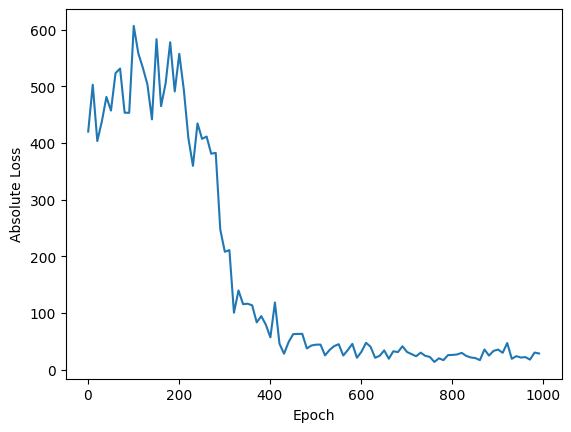

In [43]:
epochs = np.arange(1,1001,10)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses)

Evaluate and compare random example's predicted value vs real value:

In [44]:
x,y = generate_data(-100,100,1)

with torch.no_grad():
    q4_model.eval()
    y_pred = q4_model(x)
l1 = criterion(y_pred,y).item()

print(f'x1, x2 = {x[0][0]:.6f}, {x[0][1]:.6f}')
print(f'Predicted vs Actual value: {y_pred[0][0]:.6f} vs {y[0][0]:.6f}')
print(f'Test L1 Loss: {l1:.6f}')

x1, x2 = -29.687346, 57.033550
Predicted vs Actual value: -1672.898682 vs -1693.174687
Test L1 Loss: 20.276005


Generate 100 random samples to test and evaluate average loss within range of training data:

In [45]:
x_val,y_val = generate_data(-100,100,100)
q4_model.eval()

total_loss = 0
for i in range(100):
    with torch.no_grad():
        y_pred = q4_model(x_val[i])
        l1 = criterion(y_pred,y_val[i])
    total_loss+=l1

print(f'Average loss within range of training data = {total_loss/100:.6f}')

Average loss within range of training data = 25.845055


Generate 100 random samples outside range of training data and calculate average loss:

In [46]:
x_test_neg,y_test_neg = generate_data(-500,-100,50)
x_test_pos,y_test_pos = generate_data(100.01,500,50)

total_loss = 0
for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_neg[i])
        l1 = criterion(y_pred,y_test_neg[i])
    total_loss+=l1

for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_pos[i])
        l1 = criterion(y_pred,y_test_pos[i])
    total_loss+=l1

print(f'Average loss outside range of training data = {total_loss/100:.6f}')

Average loss outside range of training data = 56819.573098


# Q5:

(a)

In [47]:
class ClocksDataset(Dataset):
    """Custom Clocks Dataset"""

    def __init__(self,img_dir,transforms=None):

        self.img_dir = img_dir
        self.transforms=transforms
        
        images = []
        labels = []

        for i in range(10000):
            images.append(f"{i:04d}.png")
            labels.append(f"{i:04d}.txt")
        
        self.images = sorted(images)
        self.labels = sorted(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]
        if self.transforms:
            PIL_image = PIL.Image.open(self.img_dir + img_path)
            PIL_image = self.transforms(PIL_image)
            image = PIL_image.to(torch.float32)/255.0
        else:
            image = (read_image(self.img_dir + img_path)).to(torch.float32)/255.0
        
        label = self.read_label(self.img_dir + label_path)

        return image,label
    
    def read_label(self,label_path):
        with open(label_path) as label_file:
            raw_label = label_file.read()
        label_vals = raw_label.split(':')
        label_vals = [float(val) for val in label_vals]
        hours = label_vals[0]
        mins = label_vals[1]
        return torch.tensor((hours,mins), dtype=torch.float32)

In [48]:
batch_size = 32
dataset = ClocksDataset("clocks_dataset/train/")
train_data,validation_data = torch.utils.data.random_split(dataset,[9600,400])

In [49]:
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validation_data,batch_size=batch_size,shuffle=True)

images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 448, 448])
torch.Size([32, 2])


(b)

In [50]:
class ClocksCNN(nn.Module):
    def __init__(self):
        super(ClocksCNN,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 16 x 224 x 224
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 32 x 112 x 112
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 64 x 56 x 56
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=4), # 128 x 14 x 14
            nn.Flatten(),
            nn.Dropout(0.5)
        )

        self.MLPhours = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=12)
        )

        self.MLPmins = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=1)
        )


    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        hours = self.MLPhours(x)
        mins = self.MLPmins(x)
        return hours,mins.view(-1)

q5_model = ClocksCNN()

In [51]:
total_params = sum(p.numel() for p in q5_model.parameters() if p.requires_grad)
print(total_params)

4916621


(c)

The chosen loss function for predicting the hours hand is Cross Entropy loss, as the network is predicting a class for the hours hand, 1-12.

The chosen loss function for predicting the minutes hand is Mean Squared Error loss, as the network is predicting the minutes value using regression.

In [52]:
criterion_h = nn.CrossEntropyLoss()
criterion_m = nn.MSELoss()

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 10
optim = torch.optim.SGD(q5_model.parameters(),lr=0.005)
iterations_per_epoch=300

losses_h, losses_m = [],[]

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        labels_h,labels_m = labels[:,0],labels[:,1]
        h,m = q5_model(images)
        loss1 = criterion_h(h,labels_h.long())
        loss2 = criterion_m(m,labels_m)
        loss = loss1/3 + loss2/100
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%50 == 0:
            losses_h.append(loss1.item())
            losses_m.append(loss2.item())

        if (i+1)%100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss (hours): {:.4f}, Loss (mins): {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss1.item(), loss2.item()))

Epoch [1/10], Iteration [100/300], Loss (hours): 2.2823, Loss (mins): 205.1466
Epoch [1/10], Iteration [200/300], Loss (hours): 1.5485, Loss (mins): 109.8654
Epoch [1/10], Iteration [300/300], Loss (hours): 1.3482, Loss (mins): 207.8605
Epoch [2/10], Iteration [100/300], Loss (hours): 1.5257, Loss (mins): 197.7208
Epoch [2/10], Iteration [200/300], Loss (hours): 1.2508, Loss (mins): 130.9443
Epoch [2/10], Iteration [300/300], Loss (hours): 0.9295, Loss (mins): 165.0171
Epoch [3/10], Iteration [100/300], Loss (hours): 1.3312, Loss (mins): 162.9437
Epoch [3/10], Iteration [200/300], Loss (hours): 0.9646, Loss (mins): 189.1220
Epoch [3/10], Iteration [300/300], Loss (hours): 0.8673, Loss (mins): 108.0311
Epoch [4/10], Iteration [100/300], Loss (hours): 0.9404, Loss (mins): 98.9444
Epoch [4/10], Iteration [200/300], Loss (hours): 0.6903, Loss (mins): 109.8111
Epoch [4/10], Iteration [300/300], Loss (hours): 0.9915, Loss (mins): 142.0953
Epoch [5/10], Iteration [100/300], Loss (hours): 0.64

Export network weights

In [54]:
torch.save(q5_model.state_dict(),'weights.pkl')

Text(0.5, 1.0, 'Hours prediction loss')

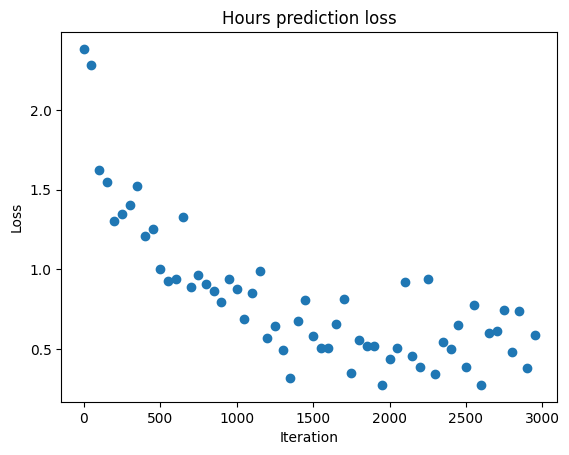

In [55]:
x = np.arange(0,3000,50)
losses_h = [val for val in losses_h]
plt.scatter(x,losses_h)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Hours prediction loss")

Text(0.5, 1.0, 'Minutes prediction loss')

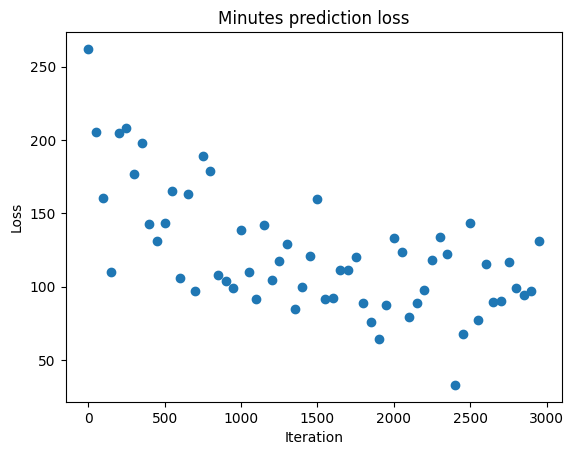

In [56]:
losses_m = [val for val in losses_m]
plt.scatter(x,losses_m)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Minutes prediction loss")

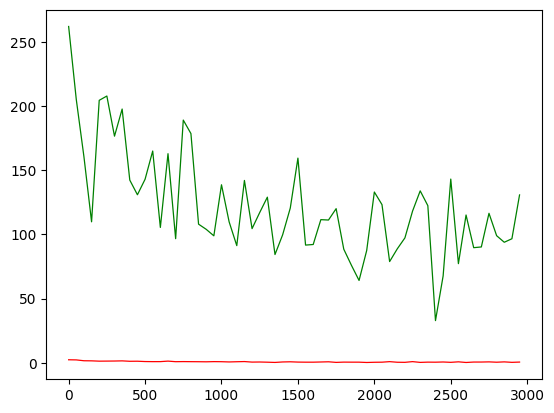

In [57]:
plt.plot(x,losses_h,'r',linewidth=0.9)
plt.plot(x,losses_m,'g',linewidth=0.9)
plt.show()

Make predictions on validation set with trained model:

In [58]:
def time_diff(hpred,mpred,h_real,m_real):
    mins_pred = hpred*60 + mpred
    mins_real = h_real*60 + m_real

    diff = abs(mins_real-mins_pred)
    return min(diff,720-diff)

In [59]:
# Uncomment to make a prediction on an item from the validation set and display

#device = torch.device("cpu")
#q5_model = q5_model.to(device)
#q5_model.load_state_dict(torch.load("weights.pkl"))
#q5_model.eval()
#images_v, labels_v = next(iter(valid_loader))

#pred_h_valid,pred_m_valid = q5_model(images_v)

#actual_time = (int(labels_v[0][0]),int(labels_v[0][1]))
# if minutes is over 60, add however many hours to the hours value and use the remainder for minutes
#prediction_mins = divmod(int(round(pred_m_valid[0].item())),60)
#predicted_time = (int(pred_h_valid[0].argmax().item())+prediction_mins[0],prediction_mins[1])
#plt.imshow(images_v[0].permute(1,2,0))
#print("Actual time: %d:%d"%(actual_time[0],actual_time[1]))
#print("Predicted time: %d:%d"%(predicted_time[0],predicted_time[1]))
#print("Error: %d"%time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

In [60]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.load_state_dict(torch.load("weights.pkl"))
q5_model.eval()
valid_errors = []
images_v, labels_v = next(iter(valid_loader))
h_pred,m_pred = q5_model(images_v)
for i in range(1):
    for j in range(len(h_pred)):
        actual_time = (int(labels_v[j][0]),int(labels_v[j][1]))
            
        prediction_mins = divmod(int(round(m_pred[j].item())),60)
        predicted_time = (int(h_pred[j].argmax().item())+prediction_mins[0],prediction_mins[1])
        valid_errors.append(time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

In [61]:
valid_errors = np.sort(valid_errors)
np.median(valid_errors)

7.0

# Q6:

In [62]:
# hyperparameters
nz = 100 # size of z vector (generator input)
nc = 3 # number of input channels (colour image so 3)
ngf = 32 # size of feature maps in generator
ndf = 32 # size of feature maps in discriminator

batch_size = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [63]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(128),transforms.Normalize(0.5,0.5)])
dataset = ClocksDataset("clocks_dataset/train/",transforms=transform)
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

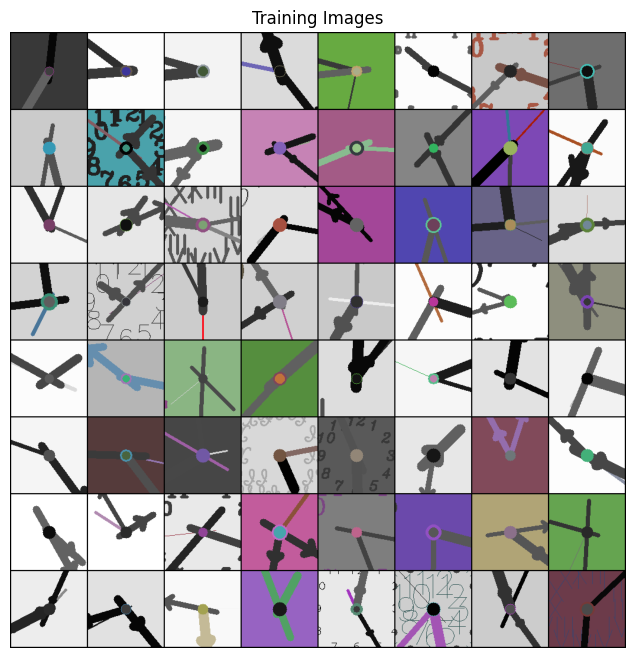

In [64]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [65]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # Z of size B x nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # Size B x (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size B x (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size B x (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size B x (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # B x (nc) x 64 x 64
        )
    
    def forward(self, input):
        return self.layers(input)

In [66]:
netG = Generator().to(device)

In [67]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size B x (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(25,1)
        )

    def forward(self,input):
        return self.layers(input)

In [68]:
netD = Discriminator().to(device)

In [69]:
criterion_q6 = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [70]:
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(dataloader,0):
        # Update D network
        # Real batch
        netD.zero_grad()
        real_images = images.to(device)
        label = torch.full((batch_size,),real_label, dtype=torch.float32,device=device)
        
        output = netD(real_images).view(-1)
        errD_real = criterion_q6(output,label)
        errD_real.backward()

        D_x = output.mean().item()

        # Fake batch
        z = torch.randn(batch_size,nz,1,1,device=device)
        fake = netG(z)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion_q6(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion_q6(output,label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 25x1)